In [88]:
import json  # Import the JSON module to read and parse JSON data

# Define the path to the JSON file containing user-app relationships
file_path = "user_app.json"  # Replace with your actual file name if needed

# Create an empty set to store unique user IDs
users = set()

# Open the JSON file in read mode with UTF-8 encoding
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:  # Iterate through each line in the file
        try:
            # Parse the line as a JSON object
            entry = json.loads(line)
            # If the parsed object contains a "user" key, add the user ID to the set
            if "user" in entry:
                users.add(entry["user"])
        except json.JSONDecodeError:
            # Skip lines that are not valid JSON
            continue

# Output the total number of distinct users found in the file
print(f"Total distinct users: {len(users)}")


Total distinct users: 10083


In [27]:
import json
from collections import defaultdict, Counter

# === Step 1: Load user → app data ===
# Open the file with user-app data (each line is a JSON object with "user" and "app")
with open("user_app.json", "r", encoding="utf-8") as f:
    # Read all lines, strip whitespace, and convert JSON strings to Python dictionaries
    user_app_data = [json.loads(line.strip()) for line in f if line.strip()]

# === Step 2: Load app → tag data into a lookup dictionary ===
# This will map each app to a set of associated tags
app_to_tags = defaultdict(set)

with open("app_tag.json", "r", encoding="utf-8") as f:
    for line in f:
        try:
            entry = json.loads(line.strip())  # Convert line to dictionary
            app = entry.get("app")            # Extract the app name
            tag = entry.get("tag")            # Extract the tag
            if app and tag:
                app_to_tags[app].add(tag)     # Add tag to the set for this app
        except json.JSONDecodeError:
            continue  # Skip lines that cannot be parsed as JSON

# === Step 3: Build a mapping from each user to a list of tags from the apps they own ===
user_tags = defaultdict(list)

for entry in user_app_data:
    user = entry.get("user")
    app = entry.get("app")
    # Only proceed if both user and app exist, and the app has associated tags
    if user and app and app in app_to_tags:
        tags = app_to_tags[app]          # Get the tags for this app
        user_tags[user].extend(tags)     # Add the tags to the user's tag list

# === Step 4: Count tag frequencies per user ===
# Turn the list of tags into a dictionary of tag counts per user
user_tag_freq = {
    user: dict(Counter(tags)) for user, tags in user_tags.items()
}

# === Step 5: Save the result to a JSON file ===
# This output will be used for clustering and recommender system input
with open("user_tag_frequency.json", "w", encoding="utf-8") as f:
    json.dump(user_tag_freq, f, indent=2)

print("✅ Created 'user_tag_frequency.json' with", len(user_tag_freq), "users.")


✅ Created 'user_tag_frequency.json' with 10083 users.


In [30]:
import pandas as pd

# Load the JSON
with open("user_tag_frequency.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to DataFrame (rows = users, columns = tags)
df = pd.DataFrame.from_dict(data, orient="index").fillna(0).astype(int)

print(df.head())  # show first few rows


                   First-Person  FPS  Competitive  Old School  Strategy  \
76561197975553057            10   10            6           7         4   
76561198019402860             1    1            1           0         2   
76561197989610401             1    2            1           0         9   
76561198040933248             3    4            0           0        10   
76561198000114197             8    6            2           3         2   

                   Assassin  Team-Based  Classic  eSports  1990's  ...  \
76561197975553057         1           5       10        1       6  ...   
76561198019402860         0           1        0        1       0  ...   
76561197989610401         0           0        3        0       0  ...   
76561198040933248         0           2        1        0       0  ...   
76561198000114197         0           1        8        0       4  ...   

                   Tile-Matching  Tennis  Solitaire  8-bit Music  BMX  \
76561197975553057              

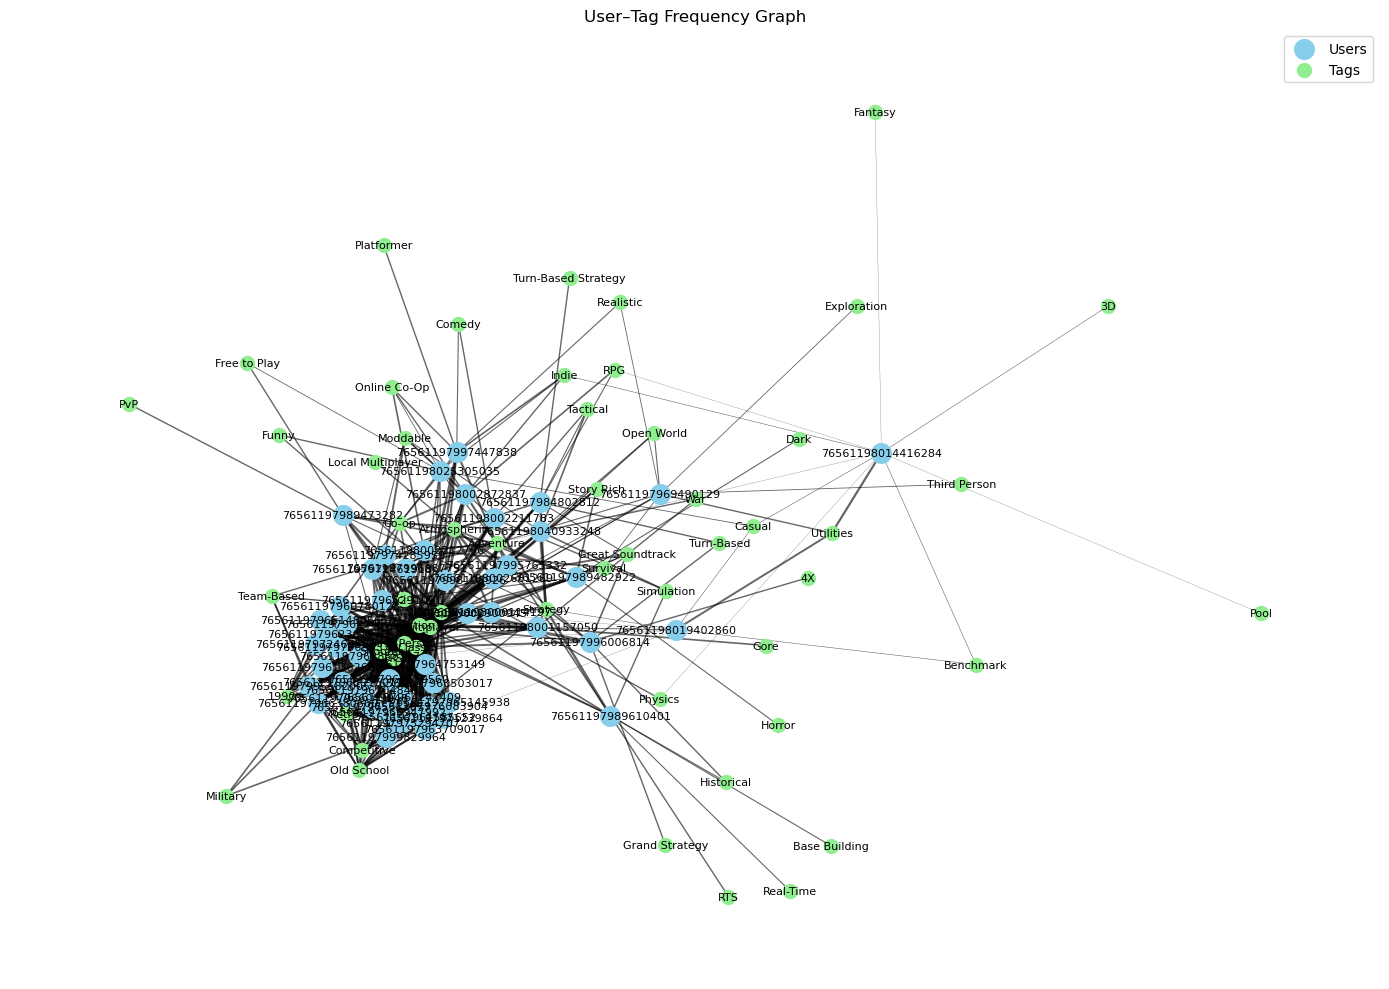

In [87]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# === Load the user-tag frequency data ===
with open("user_tag_frequency.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# === Create the NetworkX graph ===
G = nx.Graph()

max_users = 50         # Limit number of users to display
TOP_TAGS = 10          # Top N tags per user
users_shown = 0        # Counter

for user, tags in data.items():
    if users_shown >= max_users:
        break
    G.add_node(user, type='user', label=user)  # Add user node
    sorted_tags = sorted(tags.items(), key=lambda x: -x[1])[:TOP_TAGS]
    for tag, freq in sorted_tags:
        G.add_node(tag, type='tag', label=tag)  # Add tag node
        G.add_edge(user, tag, weight=freq)      # Add edge from user to tag
    users_shown += 1

# === Draw the graph ===
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.35, seed=42)  # Set seed for consistent layout

# Separate nodes
user_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'user']
tag_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'tag']

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='cornflowerblue', node_size=250, label='Users')
nx.draw_networkx_nodes(G, pos, nodelist=tag_nodes, node_color='lightcoral', node_size=150, label='Tags')

# Draw edges with weight mapped to width
weights = [min(6, d['weight'] / 5) for _, _, d in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.5)

# Optional: Draw fewer labels to avoid clutter
nx.draw_networkx_labels(G, pos, labels={n: n for n in user_nodes}, font_size=8, font_color='black')
nx.draw_networkx_labels(G, pos, labels={n: n for n in tag_nodes}, font_size=6, font_color='darkgreen')

# Final plot settings
plt.title("User–Tag Frequency Graph (Top 10 Tags, 50 Users)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()



In [49]:
import json
import pandas as pd

# === Load the JSON file ===
with open("user_tag_frequency.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# === Convert to DataFrame ===
df = pd.DataFrame.from_dict(data, orient='index').fillna(0)

# === Sum all tag frequencies across users ===
tag_totals = df.sum().sort_values(ascending=False)

# === Display Top N tags ===
top_n = 20
print(f"🏷️ Top {top_n} Most Frequent Tags:\n")
print(tag_totals.head(top_n))



🏷️ Top 20 Most Frequent Tags:

Action              91453.0
Singleplayer        77505.0
Multiplayer         74955.0
First-Person        71812.0
Shooter             71010.0
FPS                 68877.0
Classic             55904.0
Adventure           53227.0
Atmospheric         50718.0
Co-op               41944.0
Sci-fi              38940.0
Moddable            35194.0
Great Soundtrack    35060.0
Strategy            33726.0
Competitive         31648.0
Tactical            29235.0
Story Rich          28412.0
Team-Based          28241.0
Military            27934.0
Retro               27194.0
dtype: float64


In [51]:
import json
import pandas as pd

# Load the frequency data
with open("user_tag_frequency.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame.from_dict(data, orient="index").fillna(0)

# Find top 5 most common tags
top_tags = df.sum().sort_values(ascending=False).head(10).index.tolist()
print("🔍 Removing top tags:", top_tags)

# Remove those columns
df = df.drop(columns=top_tags)

# Save updated frequency data
df.to_dict(orient="index")  # you can view a preview here

with open("user_tag_frequency_no_top10.json", "w", encoding="utf-8") as f:
    json.dump(df.to_dict(orient="index"), f, indent=2)

print("✅ Cleaned file saved as 'user_tag_frequency_no_top10.json'")


🔍 Removing top tags: ['Action', 'Singleplayer', 'Multiplayer', 'First-Person', 'Shooter', 'FPS', 'Classic', 'Adventure', 'Atmospheric', 'Co-op']
✅ Cleaned file saved as 'user_tag_frequency_no_common.json'


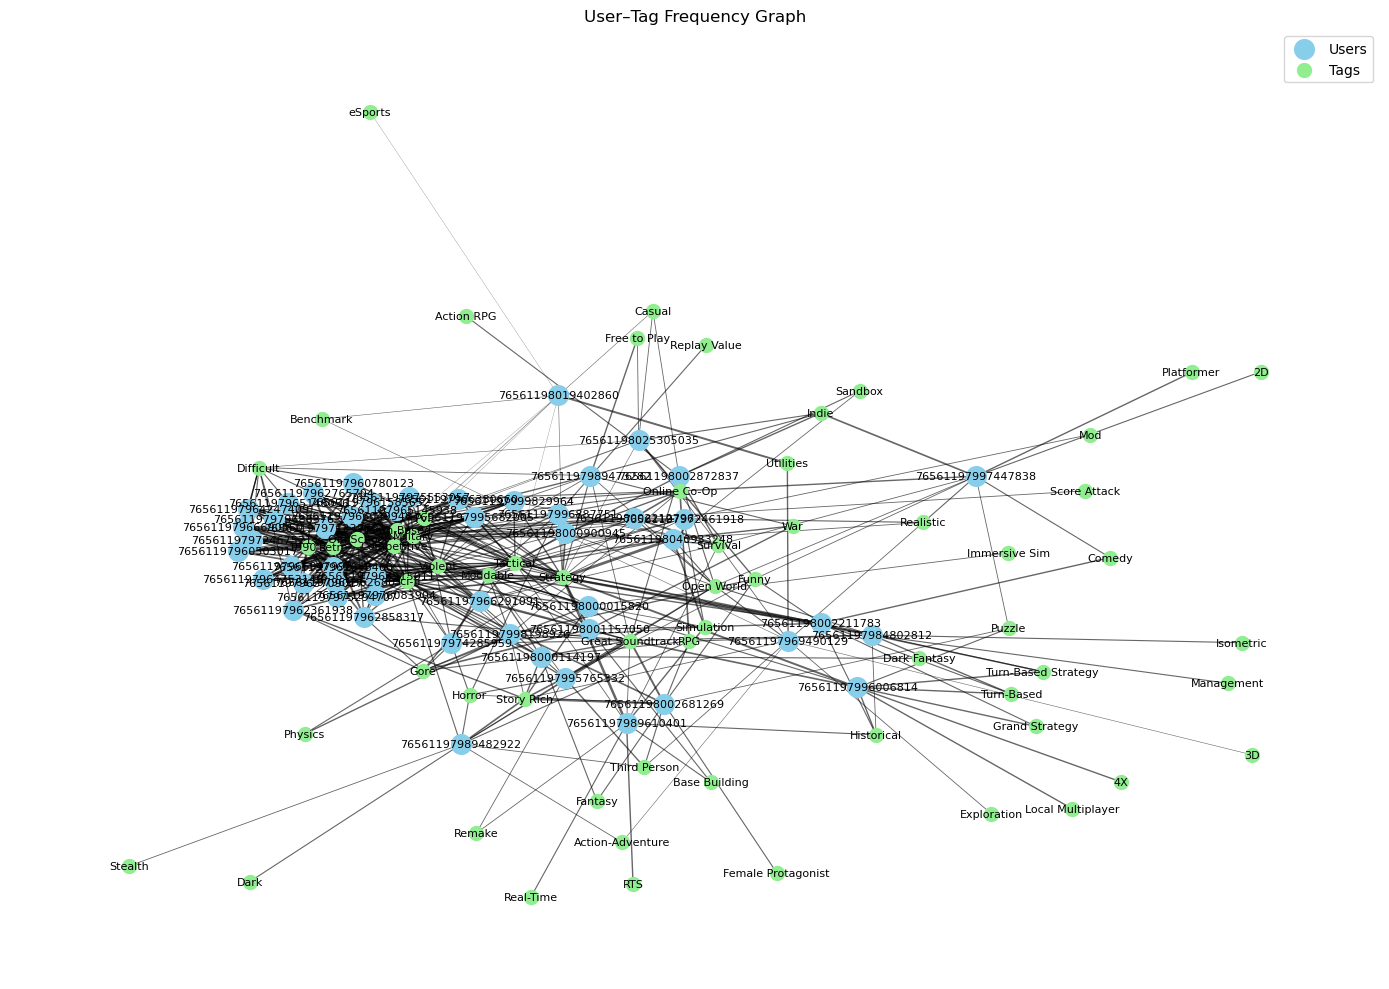

In [85]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# Load the user-tag frequency data
with open("user_tag_frequency_no_top10.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Create a NetworkX graph
G = nx.Graph()

# Limit number of users to avoid clutter (optional)
max_users = 50  # Change this as needed
users_shown = 0

TOP_TAGS = 10  # Show only top 5 tags per user

for user, tags in data.items():
    if users_shown >= max_users:
        break
    G.add_node(user, type='user')
    sorted_tags = sorted(tags.items(), key=lambda x: -x[1])[:TOP_TAGS]
    for tag, freq in sorted_tags:
        G.add_node(user, type='user')
        G.add_node(tag, type='tag')
        G.add_edge(user, tag, weight=freq)
    users_shown += 1


# Draw the graph
plt.figure(figsize=(14, 10))

# Position nodes using spring layout
pos = nx.spring_layout(G, k=0.3)

# Draw nodes
user_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'user']
tag_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'tag']

nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='skyblue', node_size=200, label='Users')
nx.draw_networkx_nodes(G, pos, nodelist=tag_nodes, node_color='lightgreen', node_size=100, label='Tags')

# Draw edges with weights mapped to width
edges = G.edges(data=True)
weights = [min(5, e['weight'] / 5) for _, _, e in edges]  # Limit max width for visibility

nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("User–Tag Frequency Graph")
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()


In [76]:
import pandas as pd
import json
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# === Load the preprocessed user-tag frequency data without the top 10 most common tags ===
with open("user_tag_frequency_no_top10.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# === Convert the JSON data into a pandas DataFrame ===
df = pd.DataFrame.from_dict(data, orient='index').fillna(0)  # Each row = user, each column = tag, value = frequency

# === Normalize each user's vector (row) so we can compare tag preferences regardless of total game count ===
X = normalize(df.values, norm='l2')  # Cosine-like normalization

# === Cluster users using MiniBatchKMeans for scalability ===
kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=1000)  # 5 clusters based on tuning + interpretability
df['cluster'] = kmeans.fit_predict(X)  # Assign a cluster ID to each user

# ✅ Save the clustered DataFrame into a JSON file that maps users to both tag frequencies and their cluster
with open("user_tag_with_clusters.json", "w", encoding="utf-8") as f:
    json.dump(df.to_dict(orient="index"), f, indent=2)

# === Print the number of users in each cluster ===
print("🔢 Users per cluster:")
print(df['cluster'].value_counts().sort_index())  # Distribution of users across clusters

# === Analyze the top 10 tags in each cluster for interpretability ===
tag_columns = df.drop(columns=['cluster']).columns

print("\n🏷️ Top 5 tags per cluster:")
for cluster_id in sorted(df['cluster'].unique()):
    print(f"\nCluster {cluster_id}")
    cluster_data = df[df['cluster'] == cluster_id]  # Subset for each cluster
    tag_totals = cluster_data[tag_columns].sum().sort_values(ascending=False)  # Sum tag frequencies across users
    print(tag_totals.head(10))  # Show the 10 most common tags in this cluster




🔢 Users per cluster:
cluster
0    2031
1    1432
2    2525
3    2574
4    1521
Name: count, dtype: int64

🏷️ Top 5 tags per cluster:

Cluster 0
Great Soundtrack    11153.0
Sci-fi              10913.0
Moddable             9944.0
Story Rich           8416.0
Horror               5984.0
Physics              5907.0
Funny                5766.0
Gore                 5748.0
Violent              5494.0
Competitive          5089.0
dtype: float64

Cluster 1
Competitive     8582.0
Old School      7953.0
Team-Based      7727.0
Military        7656.0
Strategy        7508.0
Tactical        7395.0
Violent         6554.0
Survival        5538.0
Online Co-Op    5160.0
PvP             4910.0
dtype: float64

Cluster 2
Online Co-Op        8927.0
Open World          8873.0
Indie               8044.0
RPG                 7680.0
Sandbox             6788.0
Third Person        6738.0
Funny               6457.0
Strategy            6432.0
Simulation          6236.0
Great Soundtrack    5996.0
dtype: float64

Cluster 

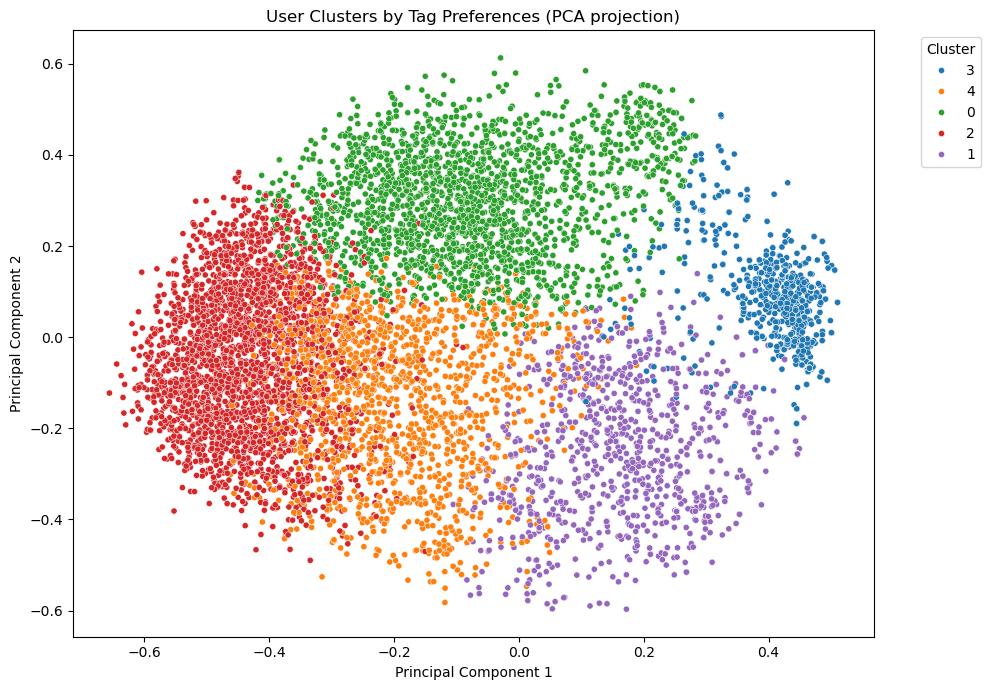

In [77]:
# === PCA for 2D visualization ===

# We reduce the high-dimensional tag data (each tag is a feature) into 2 dimensions 
# using Principal Component Analysis (PCA) so that we can visualize it on a 2D scatterplot.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # X was the normalized user-tag matrix

# === Prepare DataFrame for plotting ===

# We convert the PCA-transformed data into a DataFrame for easy plotting with seaborn.
plot_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])  # PC1 and PC2 = Principal Components
plot_df["cluster"] = df["cluster"].values.astype(str)  # Add cluster info as string labels for coloring

# === Create the scatter plot ===

plt.figure(figsize=(10, 7))  # Set figure size
sns.scatterplot(
    data=plot_df,
    x="PC1", y="PC2",        # x and y axis from PCA
    hue="cluster",           # Color each dot by its cluster
    palette="tab10",         # Use a categorical color palette
    s=20                     # Size of each dot
)
plt.title("User Clusters by Tag Preferences (PCA projection)")  # Plot title
plt.xlabel("Principal Component 1")  # X-axis label
plt.ylabel("Principal Component 2")  # Y-axis label
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()
plt.show()  # Display the plot



In [78]:
import pandas as pd
import json
from collections import defaultdict, Counter

# === Step 1: Load the user-tag-cluster data ===
# This file contains each user, their tag frequencies, and the cluster they were assigned to.
with open("user_tag_with_clusters.json", "r", encoding="utf-8") as f:
    user_tag_cluster_data = json.load(f)

# Convert it to a DataFrame and fill missing values with 0
df = pd.DataFrame.from_dict(user_tag_cluster_data, orient="index").fillna(0)
df["cluster"] = df["cluster"].astype(int)  # Make sure cluster column is treated as an integer

# === Step 2: Load mappings of which users own which games and which games have which tags ===
with open("user_app.json", "r", encoding="utf-8") as f:
    user_game_list = [json.loads(line) for line in f if line.strip()]  # Load as list of dicts

with open("app_tag.json", "r", encoding="utf-8") as f:
    game_tag_list = [json.loads(line) for line in f if line.strip()]  # Load as list of dicts

# === Step 3: Build fast-access lookup dictionaries ===
user_games = defaultdict(set)
for entry in user_game_list:
    user_games[entry["user"]].add(entry["app"])  # Which games a user owns

game_tags = defaultdict(set)
for entry in game_tag_list:
    game_tags[entry["app"]].add(entry["tag"])  # Which tags a game has

# === Step 4: For each cluster, compute the total frequency of each tag ===
cluster_tags = defaultdict(Counter)
for cluster_id in sorted(df["cluster"].unique()):
    tag_totals = df[df["cluster"] == cluster_id].drop(columns="cluster").sum()
    cluster_tags[cluster_id] = tag_totals.sort_values(ascending=False)

# === Step 5: Main loop — generate jump-tag-based recommendations for each user ===
recommendations = {}

for user_id, user_row in df.iterrows():
    cluster_id = int(user_row["cluster"])
    
    # Get top 5 tags of this user
    user_tags = user_row.drop("cluster").sort_values(ascending=False)
    user_top5 = set(user_tags.head(5).index)

    # Get top 8 tags of the user's cluster
    cluster_top8 = cluster_tags[cluster_id].head(8).index

    # Jump tags = most common cluster tags not in user's top 5
    jump_tags = [tag for tag in cluster_top8 if tag not in user_top5][:3]

    owned = user_games.get(user_id, set())  # Games the user already owns
    cluster_user_ids = df[df["cluster"] == cluster_id].index  # Users in the same cluster

    # Candidate games = popular games in cluster that have the jump tags and the user doesn’t own
    candidate_games = defaultdict(int)
    for cu in cluster_user_ids:
        for game in user_games.get(cu, []):
            if game in owned:
                continue  # Don't recommend games the user already owns
            tags = game_tags.get(game, set())
            for jt in jump_tags:
                if jt in tags:
                    candidate_games[game] += 1  # Increase score for that game

    # Select top 10 recommended games based on score
    top_games = sorted(candidate_games.items(), key=lambda x: -x[1])[:10]

    # Save recommendations for this user
    recommendations[user_id] = {
        "jump_tags": jump_tags,
        "recommended_games": [g for g, _ in top_games]
    }

# === Step 6: Save the full recommendation dictionary to a JSON file ===
with open("user_recommendations.json", "w", encoding="utf-8") as f:
    json.dump(recommendations, f, indent=2)

print("✅ Recommendations saved to 'user_recommendations.json'")


✅ Recommendations saved to 'user_recommendations.json'


In [80]:
import json

# Show the first few entries
print("🔍 First 5 user recommendations:")
for i, (user, info) in enumerate(recommendations.items()):
    print(f"\nUser: {user}")
    print(f"  Jump Tags: {info['jump_tags']}")
    print(f"  Recommended Games: {info['recommended_games']}")
    if i == 4:
        break


🔍 First 5 user recommendations:

User: 76561197975553057
  Jump Tags: ['Sci-fi', 'Military', 'Team-Based']
  Recommended Games: ['Counter-Strike: Source', 'Half-Life 2', 'Day of Defeat: Source', 'Half-Life 2: Deathmatch', 'Half-Life Deathmatch: Source', 'Half-Life: Source', 'Red Orchestra: Ostfront 41-45', 'Counter-Strike 2', "Darkest Hour: Europe '44-'45", 'Left 4 Dead 2']

User: 76561198019402860
  Jump Tags: ['Tactical', 'Moddable', 'Simulation']
  Recommended Games: ['Counter-Strike: Source', "Garry's Mod", 'Left 4 Dead 2', 'Day of Defeat: Source', 'Arma 2: Operation Arrowhead', 'Half-Life 2: Deathmatch', 'Company of Heroes - Legacy Edition', 'Red Orchestra: Ostfront 41-45', "Darkest Hour: Europe '44-'45", 'ARMA 2']

User: 76561197989610401
  Jump Tags: ['Tactical', 'Moddable', 'Military']
  Recommended Games: ['Counter-Strike: Source', 'Counter-Strike 2', "Garry's Mod", 'Left 4 Dead 2', 'Day of Defeat: Source', 'Counter-Strike', 'Counter-Strike: Condition Zero', 'Call of Duty®: Mo